# Peaking emissions

* A key step on the way to reducing emissions is for them to peak, at both a national and global level
* This notebook reads in emissions data (either national totals or subsectors) and assesses how many countries have peaked emissions. In addition, it explores which countries have emissions that may have stabilised vs. those that are clearly still increasing.
* The specific criteria for 'peaking' emissions can be set by the user, and include
    * a date since which emissions must have peaked - this removes countries whose emissions peaked since 1990 but have since increased. 
    * a more recent end year *before* which emissions must have peaked. This excludes countries whose maxima in emissions was in the last few years but not long enough ago to be sure that they will not increase again. 
    * A period over which average emissions have steadily decreased by a given threshold, e.g. average 5-yearly decrease of 1.5% per year.
    
    
TODO: 
* more sensible naming of plots? 
* somehow export the criteria for selection with the plots. 

In [1]:
# import modules

# system
import sys, os, re

# for analysis
import pandas as pd
import numpy as np

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn

# global stocktake tools
from gst_tools.make_plots import *
import gst_tools.gst_utils as utils

from shortcountrynames import to_name
from countrygroups import EUROPEAN_UNION

In [2]:
# User specs

"""
PLEASE ADJUST THE FOLLOWING FOUR PARAMETERS TO SUIT YOUR NEEDS! 
"""

# File containing data to be used:
data_file_name = 'PRIMAP-hist_v2.0_Energy-CO2.csv'

# year since which peaking must have occurred
peak_since = 2000

# number of years before end of data series BY which peak should have occurred
nyears = 4

# threshold (%) of n year decraese for positively evaluating an emissions peak
decrease_threshold = -1.5

# number of years over which emissions trend should be averaged
n_trend_years = 5 


In [3]:
# Read the data

# read the data from file 
fname_in = os.path.join('proc-data', data_file_name)
data = pd.read_csv(fname_in)

# extract the key information
variable = data['variable'].unique()[0]
unit = data['unit'].unique()[0]

# reorganise and clean the data
data_years = utils.set_countries_as_index(data)
data_years = data_years.dropna(axis=1, how='any')

# TODO - add some checks / validation

# remove comment below to display the data
#data_years

Last year of data available is 2014


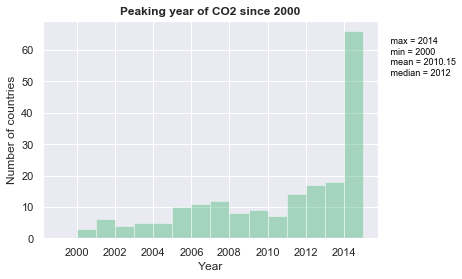

In [5]:
# Year of peaking 

"""
Makes a histogram of the year in which emissions have peaked since the start year specified above (peak_since).
"""

reduced_data = utils.change_first_year(data_years, peak_since)

year_max = reduced_data.idxmax(axis=1)
year_max = pd.to_numeric(year_max)
year_max.name = 'peak year'

start_year = min(list(map(int, data_years.columns)))
end_year = max(list(map(int, data_years.columns)))

make_histogram_peaking(year_max, variable, '', peak_since, end_year, save_plot=False)
    

In [6]:
# Interrogate the data with different conditions (peak year, decreasing rate) to categorise countries 
#    into different categories 

# set up a dataframe to store analysis results
peaking_assessment = pd.DataFrame()
peaking_assessment['max year'] = year_max
  
    
# Identify countries that have 'peaked' before the time period chosen by the user above (nyears ago)
peaking_assessment['max_reached'] = peaking_assessment['max year'].apply(
                                                                lambda x : (x < (end_year - nyears)))

# Identify countries with decreasing emissions trends
recent_trends, recent_trends_rolling, unit = utils.calculate_trends(reduced_data, num_years_trend=n_trend_years)
peaking_assessment['decreasing'] = recent_trends[str(end_year)].apply(lambda x: (x < 0))
peaking_assessment['strongly_decreasing'] = recent_trends[str(end_year)].apply(lambda x: (x < decrease_threshold))

# Use multi-criteria to define different regimes
# first, the clearer cases...
peaking_assessment['peaked']     = peaking_assessment['max_reached'] & peaking_assessment['strongly_decreasing']
peaking_assessment['stabilised'] = peaking_assessment['max_reached'] & peaking_assessment['decreasing'] & (peaking_assessment['strongly_decreasing']==False)
peaking_assessment['not_peaked'] = (peaking_assessment['max_reached']==False) & (peaking_assessment['decreasing']==False)

# then the not so clear cases - only meets one of the criteria
# note that in the second case, a max. has been reached but too recently to count
peaking_assessment['max_reached_not_decreasing'] = peaking_assessment['max_reached'] & (peaking_assessment['decreasing']==False)
peaking_assessment['recent_peak']  = (peaking_assessment['max_reached']==False) & (peaking_assessment['decreasing'])
peaking_assessment['possibly_stabilised'] = peaking_assessment['max_reached_not_decreasing'] | peaking_assessment['recent_peak']


# and use that to get some stats
share_peaked     = peaking_assessment['peaked'].value_counts(normalize=True) 
share_stabilised = peaking_assessment['stabilised'].value_counts(normalize=True)
share_possible   = peaking_assessment['possibly_stabilised'].value_counts(normalize=True)
share_increasing = peaking_assessment['not_peaked'].value_counts(normalize=True)


# and print to screen...
print('')
print('Share of countries peaked is {:.1f}%'.format(share_peaked[True]*100))
print('Share of countries stabilised is {:.1f}%'.format(share_stabilised[True]*100))
print('Share of countries possibly stabilised is {:.1f}%'.format(share_possible[True]*100))
print('Share of countries still increasing is {:.1f}%'.format(share_increasing[True]*100))
#print('Share of countries remaining is {:.1f}%'.format(share_remaining[True]*100))
print('')


Averaging trend over 5 years.

Share of countries peaked is 18.5%
Share of countries stabilised is 3.6%
Share of countries possibly stabilised is 30.8%
Share of countries still increasing is 47.2%



In [ ]:
# And make some plots to view and check the results. 

"""
These functions will plot facet grids of the emissions trends and absolute emissions
for all countries in each category. 
"""


# 1. Peaking
# prep data for plotting 
peaked_country_trends = recent_trends[peaking_assessment['peaked']]
peaked_country_abs = data_years[peaking_assessment['peaked']] 

# make the plots
plot_facet_grid_countries(peaked_country_trends, 'year', '% change', 
                          main_title='Countries with peaked emissions', 
                          plot_name=('peaked-' + variable), save_plot=True)

plot_facet_grid_countries(peaked_country_abs, 'year', 'emissions', 
                          main_title='absolute emissions for peaked countries', 
                          plot_name=('peaked-' + variable), save_plot=True)

    
# 2. Stabilised
stab_trends = recent_trends[peaking_assessment['stabilised']]
stab_abs    = data_years[peaking_assessment['stabilised']] 

plot_facet_grid_countries(stab_trends, 'year', '% change', 
                         main_title='Trends in countries with stabilised emissions', 
                         plot_name=('stabilised-' + variable), save_plot=True)
plot_facet_grid_countries(stab_abs, 'year', 'emissions', 
                         main_title='Emissions in countries with stabilised emissions', 
                         plot_name=('stabilised-' + variable), save_plot=True)


# 3. possibly stabilised
poss_stab_trends = recent_trends[peaking_assessment['possibly_stabilised']]
poss_stab_abs    = data_years[peaking_assessment['possibly_stabilised']] / 1000

plot_facet_grid_countries(poss_stab_trends, 'year', '% change', 
                         main_title='Trends in countries with possibly stabilised emissions', 
                         plot_name=('poss-stabilised-' + variable), save_plot=True)
plot_facet_grid_countries(poss_stab_abs, 'year', 'emissions', 
                         main_title='Emissions in countries with possibly stabilised emissions', 
                         plot_name=('poss-stabilised-' + variable),  save_plot=True)


# 4. still increasing
not_peaked_trends = recent_trends[peaking_assessment['not_peaked']]
not_peaked_abs    = data_years[peaking_assessment['not_peaked']] 

plot_facet_grid_countries(not_peaked_trends, 'year', '% change', 
                         main_title='Trends in countries with emissions that have not yet peaked',
                         plot_name=('not-peaked-' + variable),
                         save_plot=True)
plot_facet_grid_countries(not_peaked_abs, 'year', 'emissions', 
                         main_title='Emissions in countries with emissions that have note yet peaked', 
                         plot_name=('not-peaked-' + variable),
                         save_plot=True)


In [ ]:
# TEST CELL - CHECK THE ROLLLING AVERAGE CALCULATION IS CORRECT.
# RESULTS - YES< IT'S WORKING.

recent_trends, recent_trends_rolling, unit = calculate_trends(reduced_data, num_years_trend=5)

trends = recent_trends.loc['ZAF']
rolling = recent_trends_rolling.loc['ZAF']
abs_emis = reduced_data.loc['ZAF']

fig, ax = plt.subplots(2,1, sharex=True, sharey=False)
ax[0].plot(trends.T)
ax[0].axhline(0)
ax[0].plot(rolling.T)
#ax[1].axhline(0)
ax[1].plot(abs_emis.T)
plt.show()